## General Dataset

### Check data distribution

In [1]:
import pandas as pd
import os
data_path = '/media/erjun/OneTouchDat/dHCP'
df_brains = pd.read_excel(os.path.join(data_path,'sourcedata_dhcp.xlsx'),index_col=[0],header=0)
df_brains

,participant_id,gender,birth_age,birth_weight,singleton,session_id,scan_age,scan_head_circumference,scan_number,radiology_score,sedation
1,CC00549XX22,Female,42.000000,3.685,Single,157600,42.142857,33.5,1,2,0
2,CC00576XX16,Male,28.857143,0.850,Single,163200,35.857143,27.0,1,5,0
3,CC00576XX16,Male,28.857143,0.850,Single,178200,42.142857,33.0,2,2,0
4,CC00202XX04,Male,38.571429,2.630,Single,67800,39.285714,32.5,1,2,0
5,CC00720XX11,Female,40.428571,3.950,Single,211101,40.571429,35.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
486,CC00617XX15,Male,31.571429,1.640,Single,188400,40.142857,34.0,2,2,0
487,CC00191XX11,Male,32.714286,1.960,Single,65200,34.714286,29.6,1,3,0
488,CC00191XX11,Male,32.714286,1.960,Single,79600,40.428571,34.5,2,2,0
489,CC00588XX20,Male,38.428571,2.660,Single,183600,41.857143,35.0,1,1,0


### Find training, validating, testing index

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

X = df_brains.index.values
y = df_brains['scan_age'].values

X_train, X_validate, X_test = np.array([]),np.array([]),np.array([])

bin_ages = np.linspace(np.floor(np.min(y)),np.ceil(np.max(y)),9)
print(bin_ages)
for i_bin,v_bin in enumerate(bin_ages[0:-1]):
    X_sub = X[(y>v_bin)&(y<=bin_ages[i_bin+1])]
    y_sub = y[(y>v_bin)&(y<=bin_ages[i_bin+1])]
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, train_size=0.7, test_size=0.1, random_state=2024)
    X_validate_sub = np.array([x for x in X_sub if (x not in X_train_sub) and (x not in X_test_sub)])
    X_train = np.concatenate((X_train,X_train_sub)).astype(int)
    X_validate = np.concatenate((X_validate,X_validate_sub)).astype(int)
    X_test = np.concatenate((X_test,X_test_sub)).astype(int)
# print(X_train)
# print(X_test)
# print(X_validate)
# print(len(X_train),len(X_test),len(X_validate),len(X_train)+len(X_test)+len(X_validate))
print([x for x in X_test if (x in X_train) or (x in X_validate)])
print([x for x in X_validate if (x in X_train) or (x in X_test)])

[29.    31.125 33.25  35.375 37.5   39.625 41.75  43.875 46.   ]
[]
[]


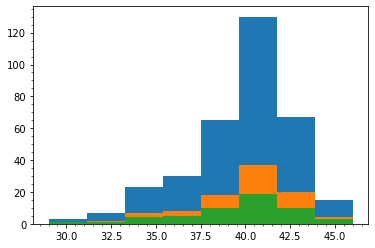

In [3]:
import matplotlib.pylab as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
data_fig_train = y[X_train-1]
data_fig_validate = y[X_validate-1]
data_fig_test = y[X_test-1]
fig,ax = plt.subplots()
ax.hist(data_fig_train,density=False,bins=bin_ages)
ax.hist(data_fig_validate,density=False,bins=bin_ages)
ax.hist(data_fig_test,density=False,bins=bin_ages)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())



### Extract data from dhcp

In [4]:
X_index = np.concatenate((X_train,X_validate,X_test))

In [5]:
import nibabel as nib
data_path = '/media/erjun/OneTouchDat/dHCP/dhcp_anat_pipeline'
data_t2w = np.zeros((len(X_index),)+(290, 290, 203,1),dtype=np.float32)
for i_index,v_index in enumerate(X_index):
    data_path_t2w = os.path.join(data_path,'sub-'+df_brains.iloc[v_index-1]['participant_id']+'/ses-'+str(df_brains.iloc[v_index-1]['session_id'])+'/anat')
    data_t2w_sub_img = nib.load(os.path.join(data_path_t2w,'sub-'+df_brains.iloc[v_index-1]['participant_id']+'_ses-'+str(df_brains.iloc[v_index-1]['session_id'])+'_desc-restore_T2w.nii.gz'))
    data_t2w_sub_mask = nib.load(os.path.join(data_path_t2w,
                                              'sub-'+df_brains.iloc[v_index-1]['participant_id']+'_ses-'+str(df_brains.iloc[v_index-1]['session_id'])+'_desc-bet_space-T2w_brainmask.nii.gz')).get_fdata()
    if data_t2w_sub_mask.shape==(290, 290, 203):
        data_t2w[i_index,:,:,:,0] = data_t2w_sub_img.get_fdata()*data_t2w_sub_mask
    else:
        print(i_index,v_index,data_t2w_sub_img.get_fdata().shape)
        data_t2w[i_index,36:-37,:,:,0] = (data_t2w_sub_img.get_fdata()*data_t2w_sub_mask)[:,:,43:-44]
np.save(os.path.join(data_path,'T2w_X_for_unet_4d.npy'),data_t2w)
np.save(os.path.join(data_path,'T2w_X_for_unet_3d.npy'),np.squeeze(data_t2w))

24 368 (217, 290, 290)
34 292 (217, 290, 290)
40 192 (217, 290, 290)
63 34 (217, 290, 290)
83 412 (217, 290, 290)
92 363 (217, 290, 290)
93 237 (217, 290, 290)
94 438 (217, 290, 290)
102 474 (217, 290, 290)
110 116 (217, 290, 290)
155 48 (217, 290, 290)
158 197 (217, 290, 290)
182 61 (217, 290, 290)
190 22 (217, 290, 290)
192 85 (217, 290, 290)
196 271 (217, 290, 290)
214 266 (217, 290, 290)
336 53 (217, 290, 290)
355 386 (217, 290, 290)
370 332 (217, 290, 290)
379 83 (217, 290, 290)
381 94 (217, 290, 290)
395 243 (217, 290, 290)
402 338 (217, 290, 290)
423 300 (217, 290, 290)
458 448 (217, 290, 290)
472 199 (217, 290, 290)
476 44 (217, 290, 290)


In [6]:
import nibabel as nib
data_path = '/media/erjun/OneTouchDat/dHCP/dhcp_anat_pipeline'
data_label9 = np.zeros((len(X_index),)+(290, 290, 203,1),dtype=np.float32)
for i_index,v_index in enumerate(X_index):
    data_path_t2w = os.path.join(data_path,'sub-'+df_brains.iloc[v_index-1]['participant_id']+'/ses-'+str(df_brains.iloc[v_index-1]['session_id'])+'/anat')
    data_t2w_sub_mask = nib.load(os.path.join(data_path_t2w,
                                              'sub-'+df_brains.iloc[v_index-1]['participant_id']+'_ses-'+str(df_brains.iloc[v_index-1]['session_id'])+'_desc-bet_space-T2w_brainmask.nii.gz')).get_fdata()
    data_label9_sub = nib.load(os.path.join(data_path_t2w,
                                              'sub-'+df_brains.iloc[v_index-1]['participant_id']+'_ses-'+str(df_brains.iloc[v_index-1]['session_id'])+'_desc-drawem9_space-T2w_dseg.nii.gz')).get_fdata()
    if data_t2w_sub_mask.shape==(290, 290, 203):
        data_label9[i_index,:,:,:,0] = data_label9_sub*data_t2w_sub_mask
    else:
        print(i_index,v_index,data_t2w_sub_mask.shape)
        data_label9[i_index,36:-37,:,:,0] = (data_label9_sub*data_t2w_sub_mask)[:,:,43:-44]
np.save(os.path.join(data_path,'T2w_y9_for_unet_4d.npy'),data_label9)
np.save(os.path.join(data_path,'T2w_y9_for_unet_3d.npy'),np.squeeze(data_label9))

24 368 (217, 290, 290)
34 292 (217, 290, 290)
40 192 (217, 290, 290)
63 34 (217, 290, 290)
83 412 (217, 290, 290)
92 363 (217, 290, 290)
93 237 (217, 290, 290)
94 438 (217, 290, 290)
102 474 (217, 290, 290)
110 116 (217, 290, 290)


In [ ]:
import nibabel as nib
data_path = '/media/erjun/OneTouchDat/dHCP/dhcp_anat_pipeline'
data_label87 = np.zeros((len(X_index),)+(290, 290, 203,1),dtype=np.float32)
for i_index,v_index in enumerate(X_index):
    data_path_t2w = os.path.join(data_path,'sub-'+df_brains.iloc[v_index-1]['participant_id']+'/ses-'+str(df_brains.iloc[v_index-1]['session_id'])+'/anat')
    data_t2w_sub_mask = nib.load(os.path.join(data_path_t2w,
                                              'sub-'+df_brains.iloc[v_index-1]['participant_id']+'_ses-'+str(df_brains.iloc[v_index-1]['session_id'])+'_desc-bet_space-T2w_brainmask.nii.gz')).get_fdata()
    data_label87_sub = nib.load(os.path.join(data_path_t2w,
                                              'sub-'+df_brains.iloc[v_index-1]['participant_id']+'_ses-'+str(df_brains.iloc[v_index-1]['session_id'])+'_desc-drawem87_space-T2w_dseg.nii.gz')).get_fdata()
    if data_t2w_sub_mask.shape==(290, 290, 203):
        data_label87[i_index,:,:,:,0] = data_label87_sub*data_t2w_sub_mask
    else:
        print(i_index,v_index,data_t2w_sub_mask.shape)
        data_label87[i_index,36:-37,:,:,0] = (data_label87_sub*data_t2w_sub_mask)[:,:,43:-44]
np.save(os.path.join(data_path,'T2w_y87_for_unet_4d.npy'),data_label87)
np.save(os.path.join(data_path,'T2w_y87_for_unet_3d.npy'),np.squeeze(data_label87))

## Create a small size of cohort

### Reduce dataset size

In [17]:
import pandas as pd
import os
data_path = '/media/erjun/OneTouchDat/dHCP'
df_brains = pd.read_excel(os.path.join(data_path,'sourcedata_dhcp.xlsx'),index_col=[0],header=0)
df_brains

,participant_id,gender,birth_age,birth_weight,singleton,session_id,scan_age,scan_head_circumference,scan_number,radiology_score,sedation
1,CC00549XX22,Female,42.000000,3.685,Single,157600,42.142857,33.5,1,2,0
2,CC00576XX16,Male,28.857143,0.850,Single,163200,35.857143,27.0,1,5,0
3,CC00576XX16,Male,28.857143,0.850,Single,178200,42.142857,33.0,2,2,0
4,CC00202XX04,Male,38.571429,2.630,Single,67800,39.285714,32.5,1,2,0
5,CC00720XX11,Female,40.428571,3.950,Single,211101,40.571429,35.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
486,CC00617XX15,Male,31.571429,1.640,Single,188400,40.142857,34.0,2,2,0
487,CC00191XX11,Male,32.714286,1.960,Single,65200,34.714286,29.6,1,3,0
488,CC00191XX11,Male,32.714286,1.960,Single,79600,40.428571,34.5,2,2,0
489,CC00588XX20,Male,38.428571,2.660,Single,183600,41.857143,35.0,1,1,0


In [18]:
import nibabel as nib
import numpy as np
data_path = '/media/erjun/OneTouchDat/dHCP/dhcp_anat_pipeline'
data_true = np.ones(len(df_brains['participant_id']),dtype=np.int8)
print(np.sum(data_true))
for i_index,v_index in enumerate(data_true):
    data_path_t2w = os.path.join(data_path,'sub-'+df_brains.iloc[i_index]['participant_id']+'/ses-'+str(df_brains.iloc[i_index]['session_id'])+'/anat')
    data_t2w_sub_mask = nib.load(os.path.join(data_path_t2w,
                                              'sub-'+df_brains.iloc[i_index]['participant_id']+'_ses-'+str(df_brains.iloc[i_index]['session_id'])+'_desc-bet_space-T2w_brainmask.nii.gz')).get_fdata()
    if data_t2w_sub_mask.shape!=(290, 290, 203):
        data_true[i_index] = 0


490


In [19]:
df_brains_small = df_brains.iloc[data_true==1]
df_brains_small

,participant_id,gender,birth_age,birth_weight,singleton,session_id,scan_age,scan_head_circumference,scan_number,radiology_score,sedation
1,CC00549XX22,Female,42.000000,3.685,Single,157600,42.142857,33.5,1,2,0
2,CC00576XX16,Male,28.857143,0.850,Single,163200,35.857143,27.0,1,5,0
3,CC00576XX16,Male,28.857143,0.850,Single,178200,42.142857,33.0,2,2,0
4,CC00202XX04,Male,38.571429,2.630,Single,67800,39.285714,32.5,1,2,0
5,CC00720XX11,Female,40.428571,3.950,Single,211101,40.571429,35.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
486,CC00617XX15,Male,31.571429,1.640,Single,188400,40.142857,34.0,2,2,0
487,CC00191XX11,Male,32.714286,1.960,Single,65200,34.714286,29.6,1,3,0
488,CC00191XX11,Male,32.714286,1.960,Single,79600,40.428571,34.5,2,2,0
489,CC00588XX20,Male,38.428571,2.660,Single,183600,41.857143,35.0,1,1,0


### Finde index of training, validating, testing dataset

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split

X = df_brains_small.index.values
y = df_brains_small['scan_age'].values

X_train, X_validate, X_test = np.array([]),np.array([]),np.array([])

bin_ages = np.linspace(31,46,9)
print(bin_ages)
for i_bin,v_bin in enumerate(bin_ages[0:-1]):
    X_sub = X[(y>v_bin)&(y<=bin_ages[i_bin+1])]
    y_sub = y[(y>v_bin)&(y<=bin_ages[i_bin+1])]
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, train_size=0.7, test_size=0.2, random_state=2024)
    X_validate_sub = np.array([x for x in X_sub if (x not in X_train_sub) and (x not in X_test_sub)])
    X_train = np.concatenate((X_train,X_train_sub)).astype(int)
    X_validate = np.concatenate((X_validate,X_validate_sub)).astype(int)
    X_test = np.concatenate((X_test,X_test_sub)).astype(int)
# print(X_train)
# print(X_test)
# print(X_validate)
# print(len(X_train),len(X_test),len(X_validate),len(X_train)+len(X_test)+len(X_validate))
print([x for x in X_test if (x in X_train) or (x in X_validate)])
print([x for x in X_validate if (x in X_train) or (x in X_test)])

[31.    32.875 34.75  36.625 38.5   40.375 42.25  44.125 46.   ]
[]
[]


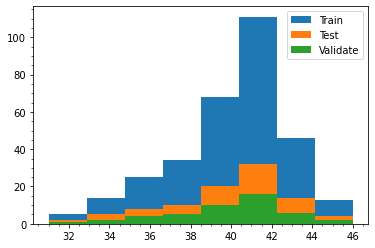

In [21]:
import matplotlib.pylab as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
data_fig_train = df_brains_small['scan_age'][X_train]
data_fig_validate = df_brains_small['scan_age'][X_validate]
data_fig_test = df_brains_small['scan_age'][X_test]
fig,ax = plt.subplots()
ax.hist(data_fig_train,density=False,bins=bin_ages,label='Train')

ax.hist(data_fig_test,density=False,bins=bin_ages,label='Test')
ax.hist(data_fig_validate,density=False,bins=bin_ages,label='Validate')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.legend()
plt.savefig('./image/data_distribution_small_subjects.png',dpi=600,bbox_inches='tight',pad_inches=0.05)

In [22]:

X_index = np.concatenate((X_train,X_validate,X_test))
with pd.ExcelWriter("./Document/subjects_all.xlsx") as writer:
    df_brains_small.loc[X_index].to_excel(writer,sheet_name="all subjects")
    df_brains_small.loc[X_train].to_excel(writer,sheet_name="train")
    df_brains_small.loc[X_validate].to_excel(writer,sheet_name="validate")
    df_brains_small.loc[X_test].to_excel(writer,sheet_name="test")
print(len(X_index),len(X_train),len(X_validate),len(X_test))


457 316 46 95


## Make Smaller size of dataset

### Reduce dataset size by set training ratio

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

X = df_brains_small.index.values
y = df_brains_small['scan_age'].values

X_train, X_validate, X_test = np.array([]),np.array([]),np.array([])

bin_ages = np.linspace(32,46,9)
print(bin_ages)
for i_bin,v_bin in enumerate(bin_ages[0:-1]):
    X_sub = X[(y>v_bin)&(y<=bin_ages[i_bin+1])]
    y_sub = y[(y>v_bin)&(y<=bin_ages[i_bin+1])]
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, train_size=0.25*0.7, test_size=0.25*0.2, random_state=2024)
    X_validate_sub = np.array([x for x in X_sub if (x not in X_train_sub) and (x not in X_test_sub)])
    X_train = np.concatenate((X_train,X_train_sub)).astype(int)
    X_validate = np.concatenate((X_validate,X_validate_sub)).astype(int)
    X_test = np.concatenate((X_test,X_test_sub)).astype(int)
# print([x for x in X_test if (x in X_train) or (x in X_validate)])
# print([x for x in X_validate if (x in X_train) or (x in X_test)])

[32.   33.75 35.5  37.25 39.   40.75 42.5  44.25 46.  ]


In [7]:
print(len(df_brains_small.index.values)*0.25)
print(len(X_validate))
12/354

115.5
354


0.03389830508474576

### Find index of dataset of validation

In [8]:
X = X_validate
y = df_brains_small['scan_age'].loc[X]

X_train_, X_validate, X_test_ = np.array([]),np.array([]),np.array([])
for i_bin,v_bin in enumerate(bin_ages[0:-1]):
    X_sub = X[(y>v_bin)&(y<=bin_ages[i_bin+1])]
    y_sub = y[(y>v_bin)&(y<=bin_ages[i_bin+1])]
    # print(i_bin,v_bin,len(X_sub)*0.03389830508474576)
    if len(X_sub)*0.03389830508474576<1:
        X_train_sub = np.array([X_sub[0]],dtype=int)
    else:
        X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, train_size=0.03389830508474576, test_size=0.1, random_state=2024)
    X_train_ = np.concatenate((X_train_,X_train_sub)).astype(int)
X_validate = X_train_

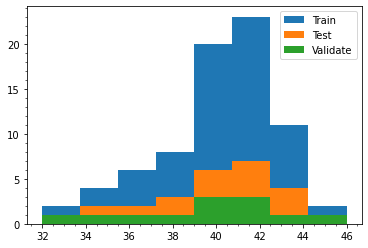

In [11]:
import matplotlib.pylab as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


data_fig_train = df_brains_small['scan_age'][X_train]
data_fig_validate = df_brains_small['scan_age'][X_validate]
data_fig_test = df_brains_small['scan_age'][X_test]
fig,ax = plt.subplots()
ax.hist(data_fig_train,density=False,bins=bin_ages,label='Train')

ax.hist(data_fig_test,density=False,bins=bin_ages,label='Test')
ax.hist(data_fig_validate,density=False,bins=bin_ages,label='Validate')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.legend()
plt.savefig('./image/data_distribution_114_subjects.png',dpi=600,bbox_inches='tight',pad_inches=0.05)

In [16]:

X_index = np.concatenate((X_train,X_validate,X_test))
with pd.ExcelWriter("./Document/subjects.xlsx") as writer:
    df_brains_small.loc[X_index].to_excel(writer,sheet_name="all subjects")
    df_brains_small.loc[X_train].to_excel(writer,sheet_name="train")
    df_brains_small.loc[X_validate].to_excel(writer,sheet_name="validate")
    df_brains_small.loc[X_test].to_excel(writer,sheet_name="test")
print(len(X_index),len(X_train),len(X_validate),len(X_test))


114 76 12 26


### Extract dataset

In [221]:
import nibabel as nib
data_path = '/media/erjun/OneTouchDat/dHCP/dhcp_anat_pipeline'
data_t2w = np.zeros((len(X_index),)+(290, 290, 203,1),dtype=np.float32)
for i_index,v_index in enumerate(X_index):
    data_path_t2w = os.path.join(data_path,'sub-'+df_brains.loc[v_index]['participant_id']+'/ses-'+str(df_brains.loc[v_index]['session_id'])+'/anat')
    data_t2w_sub_img = nib.load(os.path.join(data_path_t2w,'sub-'+df_brains.loc[v_index]['participant_id']+'_ses-'+str(df_brains.loc[v_index]['session_id'])+'_desc-restore_T2w.nii.gz'))
    data_t2w_sub_mask = nib.load(os.path.join(data_path_t2w,
                                              'sub-'+df_brains.loc[v_index]['participant_id']+'_ses-'+str(df_brains.loc[v_index]['session_id'])+'_desc-bet_space-T2w_brainmask.nii.gz')).get_fdata()
    if data_t2w_sub_mask.shape==(290, 290, 203):
        data_t2w[i_index,:,:,:,0] = data_t2w_sub_img.get_fdata()*data_t2w_sub_mask
    else:
        print(i_index,v_index,data_t2w_sub_img.get_fdata().shape)
        data_t2w[i_index,36:-37,:,:,0] = (data_t2w_sub_img.get_fdata()*data_t2w_sub_mask)[:,:,43:-44]
np.save(os.path.join(data_path,'T2w_X_114_for_unet_4d.npy'),data_t2w)
np.save(os.path.join(data_path,'T2w_X_114_for_unet_3d.npy'),np.squeeze(data_t2w))

In [224]:
import nibabel as nib
data_path = '/media/erjun/OneTouchDat/dHCP/dhcp_anat_pipeline'
data_label9 = np.zeros((len(X_index),)+(290, 290, 203,1),dtype=np.float32)
for i_index,v_index in enumerate(X_index):
    data_path_t2w = os.path.join(data_path,'sub-'+df_brains.loc[v_index]['participant_id']+'/ses-'+str(df_brains.loc[v_index]['session_id'])+'/anat')
    data_t2w_sub_mask = nib.load(os.path.join(data_path_t2w,
                                              'sub-'+df_brains.loc[v_index]['participant_id']+'_ses-'+str(df_brains.loc[v_index]['session_id'])+'_desc-bet_space-T2w_brainmask.nii.gz')).get_fdata()
    data_label9_sub = nib.load(os.path.join(data_path_t2w,
                                              'sub-'+df_brains.loc[v_index]['participant_id']+'_ses-'+str(df_brains.loc[v_index]['session_id'])+'_desc-drawem9_space-T2w_dseg.nii.gz')).get_fdata()
    if data_t2w_sub_mask.shape==(290, 290, 203):
        data_label9[i_index,:,:,:,0] = data_label9_sub#*data_t2w_sub_mask
    else:
        print(i_index,v_index,data_t2w_sub_mask.shape)
        data_label9[i_index,36:-37,:,:,0] = (data_label9_sub*data_t2w_sub_mask)[:,:,43:-44]
np.save(os.path.join(data_path,'T2w_y9_small_for_unet_4d.npy'),data_label9.astype(np.int8))
np.save(os.path.join(data_path,'T2w_y9_small_for_unet_3d.npy'),data_label9[...,0].astype(np.int8))

In [223]:
import nibabel as nib
data_path = '/media/erjun/OneTouchDat/dHCP/dhcp_anat_pipeline'
data_label9 = np.zeros((len(X_index),)+(290, 290, 203,1),dtype=np.float32)
for i_index,v_index in enumerate(X_index):
    data_path_t2w = os.path.join(data_path,'sub-'+df_brains.loc[v_index]['participant_id']+'/ses-'+str(df_brains.loc[v_index]['session_id'])+'/anat')
    data_t2w_sub_mask = nib.load(os.path.join(data_path_t2w,
                                              'sub-'+df_brains.loc[v_index]['participant_id']+'_ses-'+str(df_brains.loc[v_index]['session_id'])+'_desc-bet_space-T2w_brainmask.nii.gz')).get_fdata()
    data_label9_sub = nib.load(os.path.join(data_path_t2w,
                                              'sub-'+df_brains.loc[v_index]['participant_id']+'_ses-'+str(df_brains.loc[v_index]['session_id'])+'_desc-drawem87_space-T2w_dseg.nii.gz')).get_fdata()
    if data_t2w_sub_mask.shape==(290, 290, 203):
        data_label9[i_index,:,:,:,0] = data_label9_sub#*data_t2w_sub_mask
    else:
        print(i_index,v_index,data_t2w_sub_mask.shape)
        data_label9[i_index,36:-37,:,:,0] = (data_label9_sub*data_t2w_sub_mask)[:,:,43:-44]
np.save(os.path.join(data_path,'T2w_y87_small_for_unet_4d.npy'),data_label9.astype(np.int8))
np.save(os.path.join(data_path,'T2w_y87_small_for_unet_3d.npy'),data_label9[...,0].astype(np.int8))